# English Premier League Analysis
## From this analysis I would like to know:
> - What makes a team to get into top 4 in the league so that they are qualified to participate in Champions League?  
- Can we predict which teams are going to be in top4 based on team's statistics?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
import matplotlib.patches as mpatches
import random
import warnings
import datetime
import platform
import easyPlot
import time

from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn import preprocessing
import sklearn
from xgboost import XGBClassifier, plot_tree


%matplotlib inline
plt.style.use('seaborn-whitegrid')
warnings.filterwarnings("ignore")

In [2]:
# load dataset
if platform.system() == 'Windows':
    tables = pd.read_csv('tables_crawler/tables_crawler/spiders/tables.csv')
    clubstats = pd.read_csv('clubstats_crawler/clubstats_crawler/spiders/clubstats.csv')
else:
    tables = pd.read_csv('data/tables.csv')
    clubstats = pd.read_csv('data/clubstats.csv')

In [3]:
tables.shape

(566, 8)

In [4]:
clubstats.shape

(566, 15)

In [5]:
tables.head()

,club_name,drawn,goal,goal_against,lost,points,position,won
0,Liverpool,1,66,21,1,82,1,27
1,Manchester City,3,68,31,7,57,2,18
2,Leicester City,5,58,28,8,53,3,16
3,Chelsea,6,51,39,9,48,4,14
4,Manchester United,9,44,30,8,45,5,12


In [6]:
clubstats.head()

,aerial_battles,big_chance_created,clearance,club_name,cross,cross_accuracy,goal_conceded_per_match,goal_per_match,interceptions,pass_accuracy,pass_per_game,season,shooting_accuracy,shot_on_target,tackle_success
0,"1,853",38,519,Arsenal,548,22%,1.29,1.43,258,84%,507.11,2019/20,35%,109,58%
1,"2,489",72,762,Arsenal,605,21%,1.34,1.92,412,83%,547.50,2018/19,36%,170,60%
2,"2,660",81,829,Arsenal,572,21%,1.34,1.95,427,84%,619.05,2017/18,39%,234,68%
3,"2,762",55,838,Arsenal,697,22%,1.16,2.03,536,84%,563.00,2016/17,36%,201,70%
4,"2,785",88,849,Arsenal,754,25%,0.95,1.71,734,84%,559.18,2015/16,37%,211,73%


**Total rows: 566, Total cols: 23**

## Data Preprocessing
> - Change into proper data types  
- Handling NA values

In [7]:
tables.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   club_name     566 non-null    object
 1   drawn         566 non-null    int64 
 2   goal          566 non-null    int64 
 3   goal_against  566 non-null    int64 
 4   lost          566 non-null    int64 
 5   points        566 non-null    int64 
 6   position      566 non-null    int64 
 7   won           566 non-null    int64 
dtypes: int64(7), object(1)
memory usage: 35.5+ KB


### 'tables' is already in proper data types. Also no NA values.

In [8]:
clubstats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   aerial_battles           566 non-null    object 
 1   big_chance_created       566 non-null    int64  
 2   clearance                566 non-null    object 
 3   club_name                566 non-null    object 
 4   cross                    566 non-null    object 
 5   cross_accuracy           566 non-null    object 
 6   goal_conceded_per_match  566 non-null    float64
 7   goal_per_match           566 non-null    float64
 8   interceptions            566 non-null    int64  
 9   pass_accuracy            566 non-null    object 
 10  pass_per_game            566 non-null    float64
 11  season                   566 non-null    object 
 12  shooting_accuracy        566 non-null    object 
 13  shot_on_target           566 non-null    int64  
 14  tackle_success           5

In [9]:
# Change to proper data types
clubstats['cross_accuracy'] = clubstats['cross_accuracy'].map(lambda x: x.rstrip('%')).astype('int')
clubstats['pass_accuracy'] = clubstats['pass_accuracy'].map(lambda x: x.rstrip('%')).astype('int')
clubstats['shooting_accuracy'] = clubstats['shooting_accuracy'].map(lambda x: x.rstrip('%')).astype('int')
clubstats['tackle_success'] = clubstats['tackle_success'].map(lambda x: x.rstrip('%')).astype('int')
clubstats['aerial_battles'] = clubstats['aerial_battles'].str.replace(',','').astype('int')
clubstats['clearance'] = clubstats['clearance'].str.replace(',','').astype('int')
clubstats['cross'] = clubstats['cross'].str.replace(',','').astype('int')

# In 'clubstats' AFC Bournemouth is named as it is, but in 'tables' it is named as 'Bournemouth'.
# So in order to join the two data frames, the club_name for AFC Bournmouth has to be changed.
clubstats['club_name'][53] = 'Bournemouth'
clubstats['club_name'][54] = 'Bournemouth'
clubstats['club_name'][55] = 'Bournemouth'
clubstats['club_name'][56] = 'Bournemouth'
clubstats['club_name'][57] = 'Bournemouth'

### Need to join two tables, but there is no column that indicate what season it is on 'tables'.  Data were scraped descending order, which is 2019 to 1992, we just need to add the information on 'tables'.

In [10]:
season_info = clubstats[clubstats['club_name'] == "Arsenal"]['season']
seasons = []

for i in range(len(season_info)):
    if i < 25:
        seasons.append([season_info[i],] * 20)
    else:
        seasons.append([season_info[i],] * 22)

seasons_flat = [season for sub_season in seasons for season in sub_season]
tables['season'] = seasons_flat

# Join two data frames
data = pd.merge(tables, clubstats, on=['club_name', 'season'])

# To get total number of games
data['total_games'] = data['won'] + data['drawn'] + data['lost']
# Add top4 indicator 
data['is_top4'] = data['position'].apply(lambda x: 1 if (x <= 4) else 0)

In [11]:
data.head()

,club_name,drawn,goal,goal_against,lost,points,position,won,season,aerial_battles,...,goal_conceded_per_match,goal_per_match,interceptions,pass_accuracy,pass_per_game,shooting_accuracy,shot_on_target,tackle_success,total_games,is_top4
0,Liverpool,1,66,21,1,82,1,27,2019/20,1982,...,0.72,2.28,267,84,622.17,39,176,60,29,1
1,Manchester City,3,68,31,7,57,2,18,2019/20,1747,...,1.11,2.43,263,89,675.89,35,192,58,28,1
2,Leicester City,5,58,28,8,53,3,16,2019/20,2183,...,1.03,2.00,330,82,516.31,38,154,58,29,1
3,Chelsea,6,51,39,9,48,4,14,2019/20,2265,...,1.34,1.76,363,85,602.00,35,169,56,29,1
4,Manchester United,9,44,30,8,45,5,12,2019/20,2018,...,1.03,1.52,286,82,503.31,39,166,57,29,0


In [12]:
# Since I want to predict top4 for this season, I will exclude this season (train ans test set)
current_season = data[data['season'] == '2019/20']
past_seasons = data[data['season'] != '2019/20'].reset_index(drop=True)

## Exploratory Data Analysis 

In [13]:
# Visual parameters
t4_color = '#3d195b'
b4_color = '#c9d6df'
b_color = '#f7f7f7'
seaborn_color = [b4_color, t4_color]
sns.set_palette(sns.color_palette(seaborn_color))
t4_legend = mpatches.Patch(color=t4_color, label='Top 4', edgecolor='black')
b4_legend = mpatches.Patch(color=b4_color, label='Below 4', edgecolor='black')

In [14]:
top4 = past_seasons[past_seasons['is_top4'] == 1]
below4 = past_seasons[past_seasons['is_top4'] == 0]

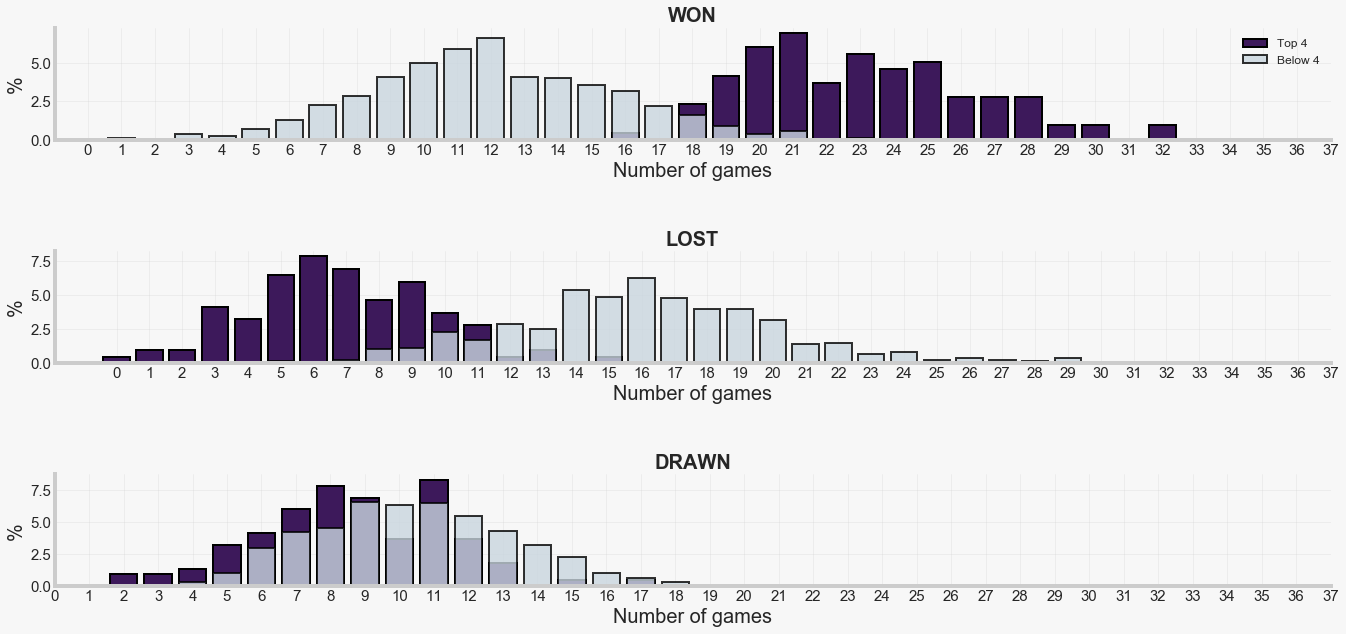

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(20,10))
cols = ['won', 'lost', 'drawn']

for i, col in enumerate(cols):
    t4_index = top4[col].value_counts().index
    t4_values = top4[col].value_counts().values
    b4_index = below4[col].value_counts().index
    b4_values = below4[col].value_counts().values
    
    ax.flatten()[i].bar(x=t4_index, height=t4_values/1.08, color=t4_color, edgecolor='black', alpha=1, linewidth=2, label='Top 4')
    ax.flatten()[i].bar(x=b4_index, height=b4_values/4.38, color=b4_color, edgecolor='black', alpha=0.8, linewidth=2, label='Below 4')
    
    ax.flatten()[i].grid(which='major', axis='x', zorder=0, alpha=0.3)
    ax.flatten()[i].grid(which='major', axis='y', zorder=0, alpha=0.3)
    
    ax.flatten()[i].set_xticks(np.arange(0, 38, 1))
    ax.flatten()[i].set_xticklabels(ax.flatten()[i].get_xticks(), fontsize=15)
    ax.flatten()[i].set_yticklabels(ax.flatten()[i].get_yticks(), fontsize=15)
    ax.flatten()[i].set_xlabel('Number of games', fontsize=20)
    ax.flatten()[i].set_ylabel('%', fontsize=20)
    ax.flatten()[i].set_title(col.upper(), weight='bold', fontsize=20)
    ax.flatten()[i].set_facecolor(b_color)
    
    ax.flatten()[i].spines['top'].set_visible(False)
    ax.flatten()[i].spines['right'].set_visible(False)
    ax.flatten()[i].spines['bottom'].set_linewidth(4)
    ax.flatten()[i].spines['left'].set_linewidth(4)
    
    if i == 0:
        ax.flatten()[i].legend(loc=1, shadow=True, fontsize=12)
        
    

fig.set_facecolor(b_color)
fig.set_edgecolor('black')
fig.tight_layout(pad=5)
plt.show()

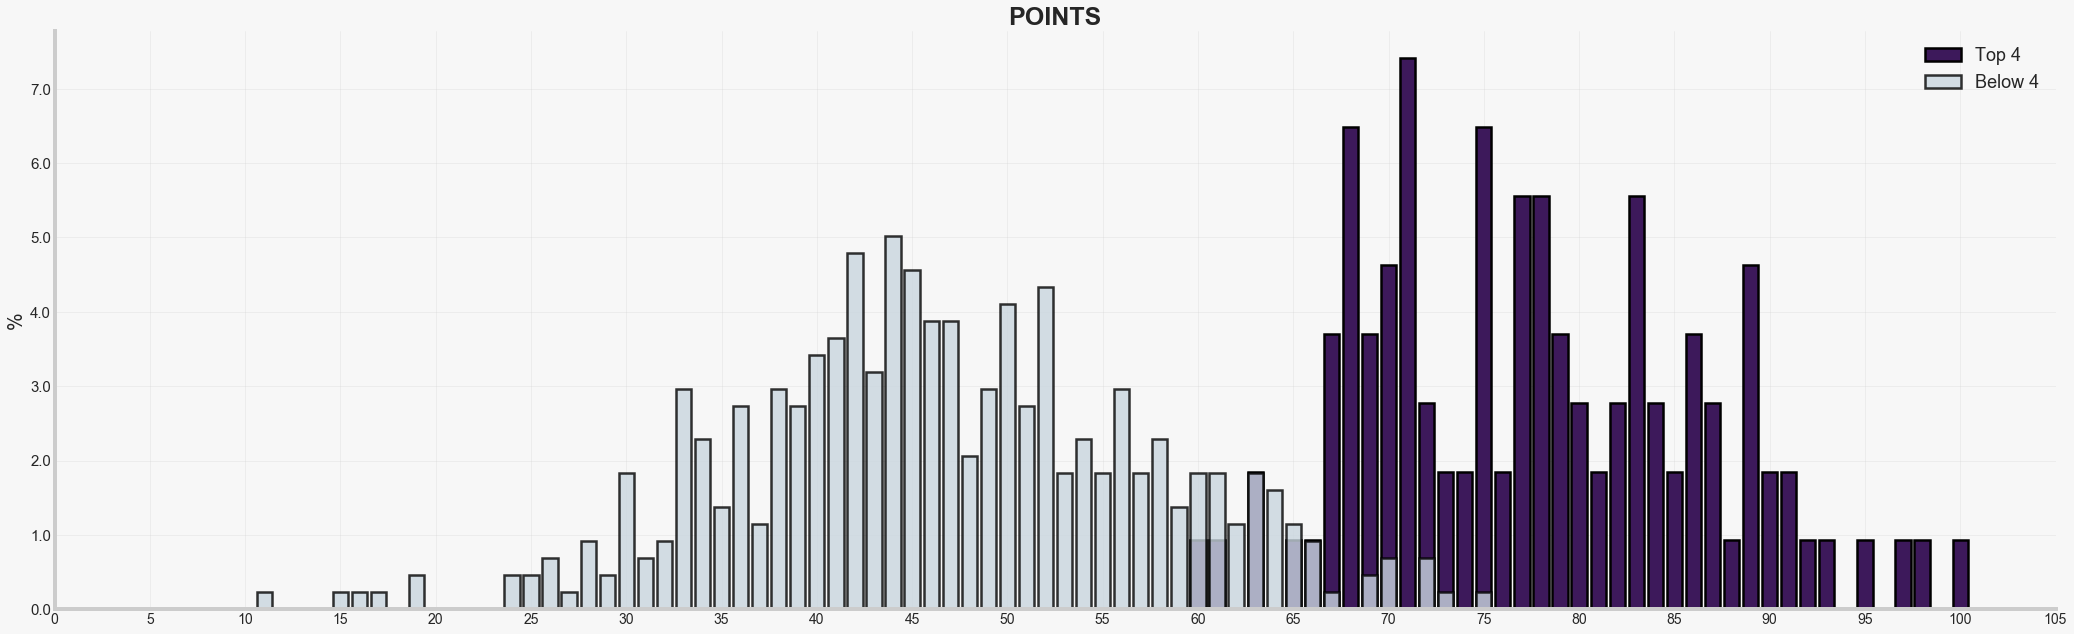

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(30,10))
col = 'points'

t4_index = top4[col].value_counts().index
t4_values = top4[col].value_counts().values
b4_index = below4[col].value_counts().index
b4_values = below4[col].value_counts().values

ax.bar(x=t4_index, height=t4_values/1.08, color=t4_color, edgecolor='black', alpha=1, linewidth=2.5, label='Top 4')
ax.bar(x=b4_index, height=b4_values/4.38, color=b4_color, edgecolor='black', alpha=0.8, linewidth=2.5, label='Below 4')

ax.grid(which='major', axis='x', zorder=0, alpha=0.3)
ax.grid(which='major', axis='y', zorder=0, alpha=0.3)

ax.set_xticks(np.arange(0, 110, 5))
ax.set_title(col.upper(), weight='bold', fontsize=25)
ax.set_ylabel('%', fontsize=20)
ax.set_xticklabels(ax.get_xticks(), fontsize=20)
ax.set_yticklabels(ax.get_yticks(), fontsize=15)
ax.xaxis.set_tick_params(labelsize=14)
ax.set_facecolor(b_color)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)

ax.legend(loc=1, shadow=True, fontsize=18)

fig.set_facecolor(b_color)
fig.tight_layout(pad=5)
plt.show()

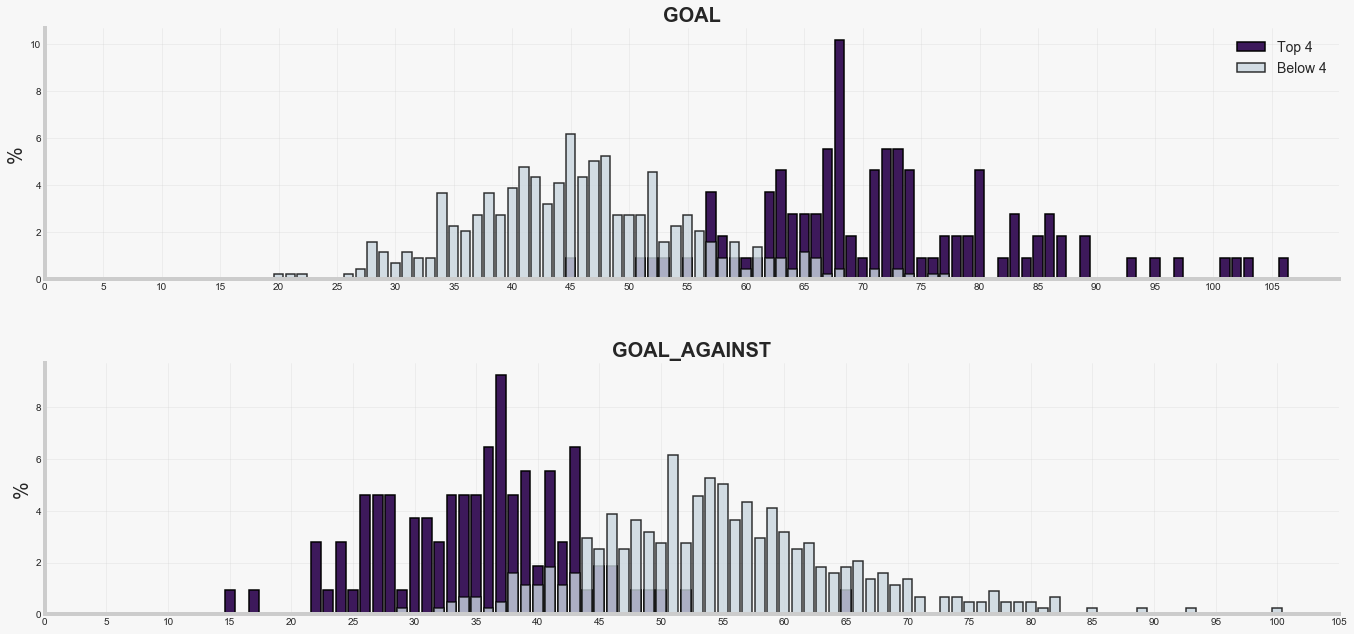

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(20,10))
cols = ['goal', 'goal_against']

for i, col in enumerate(cols):
    t4_index = top4[col].value_counts().index
    t4_values = top4[col].value_counts().values
    b4_index = below4[col].value_counts().index
    b4_values = below4[col].value_counts().values
    
    ax.flatten()[i].bar(x=t4_index, height=t4_values/1.08, color=t4_color, edgecolor='black', alpha=1, linewidth=1.5, label='Top 4')
    ax.flatten()[i].bar(x=b4_index, height=b4_values/4.38, color=b4_color, edgecolor='black', alpha=0.8, linewidth=1.5, label='Below 4')
    
    ax.flatten()[i].grid(which='major', axis='x', zorder=0, alpha=0.3)
    ax.flatten()[i].grid(which='major', axis='y', zorder=0, alpha=0.3)
    
    ax.flatten()[i].set_xticks(np.arange(0, 110, 5))
    ax.flatten()[i].set_title(col.upper(), weight='bold', fontsize=20)
    ax.flatten()[i].set_ylabel('%', fontsize=20)
    ax.flatten()[i].set_facecolor(b_color)
    
    ax.flatten()[i].spines['top'].set_visible(False)
    ax.flatten()[i].spines['right'].set_visible(False)
    ax.flatten()[i].spines['bottom'].set_linewidth(4)
    ax.flatten()[i].spines['left'].set_linewidth(4)
    
    if i == 0:
        ax.flatten()[i].legend(loc=1, shadow=True, fontsize=14)

fig.set_facecolor(b_color)
fig.set_edgecolor('black')
fig.tight_layout(pad=5)
plt.show()

In [18]:
seasons = np.flip(data['season'].unique())

t4_legend = mpatches.Patch(color=t4_color, label='Top 4', edgecolor='black')
b4_legend = mpatches.Patch(color=b4_color, label='Below 4', edgecolor='black')

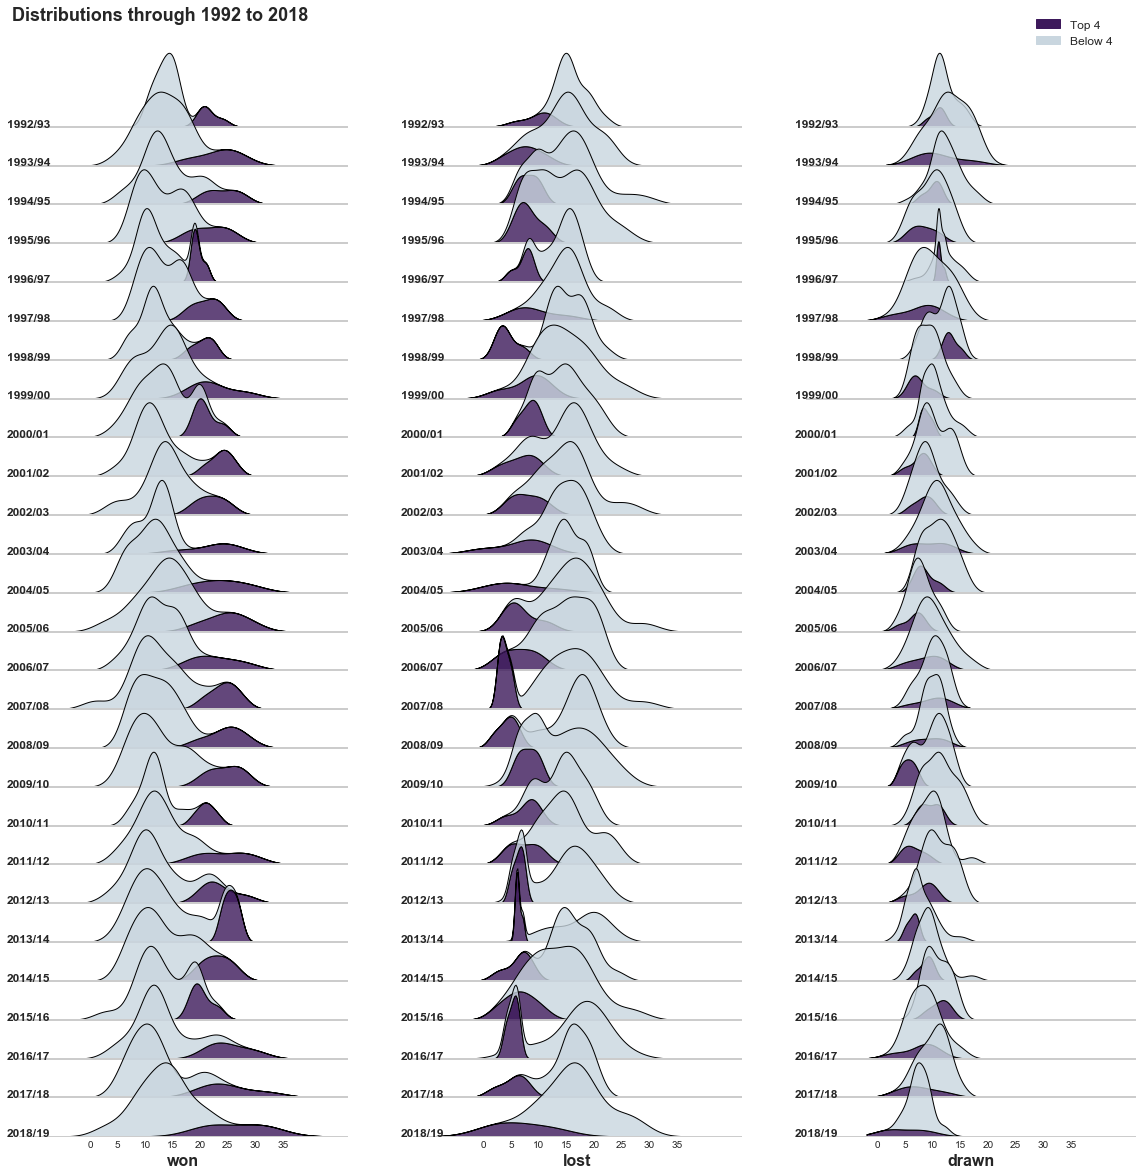

In [19]:
cols = ['won', 'lost', 'drawn']

fig, ax = plt.subplots(len(seasons[:-1]), 3, figsize=(20, 20), 
                       sharex=True, gridspec_kw={'hspace':-0.5}, tight_layout=True)

for i, col in enumerate(cols):
    for j, season in enumerate(seasons[:-1]):
        sns.kdeplot(data=data[data['season'] == season], x=col, hue='is_top4',  alpha=.8, 
                    edgecolor='black', multiple='stack', legend=False, ax=ax[j, i])
        ax[j, i].spines['top'].set_visible(False)
        ax[j, i].spines['right'].set_visible(False)
        ax[j, i].spines['left'].set_visible(False)
        ax[j, i].grid(False)
        ax[j, i].get_yaxis().set_visible(False)
        ax[j, i].set_facecolor('None')

        if j != len(seasons[:-1])-1:
            ax[j, i].spines['bottom'].set_linewidth(2)
            ax[j, i].set_xticks(np.arange(0, 40, 5))
            ax[j, i].get_xaxis().set_visible(False)
            ax[j, i].text(-15, 0, season, fontweight='bold', fontsize=12)
        else:
            ax[j, i].get_xaxis().set_visible(True)
            ax[j, i].text(-15, 0, season, fontweight='bold', fontsize=12)
            ax[j, i].set_xlabel(col, fontsize=16, fontweight='bold')

fig.legend(bbox_to_anchor=(0.78, 0.81), handles=[t4_legend, b4_legend], shadow=True, fontsize=12)
fig.text(0.12, 0.9, 'Distributions through 1992 to 2018', fontsize=18, fontweight='bold')     
plt.show()

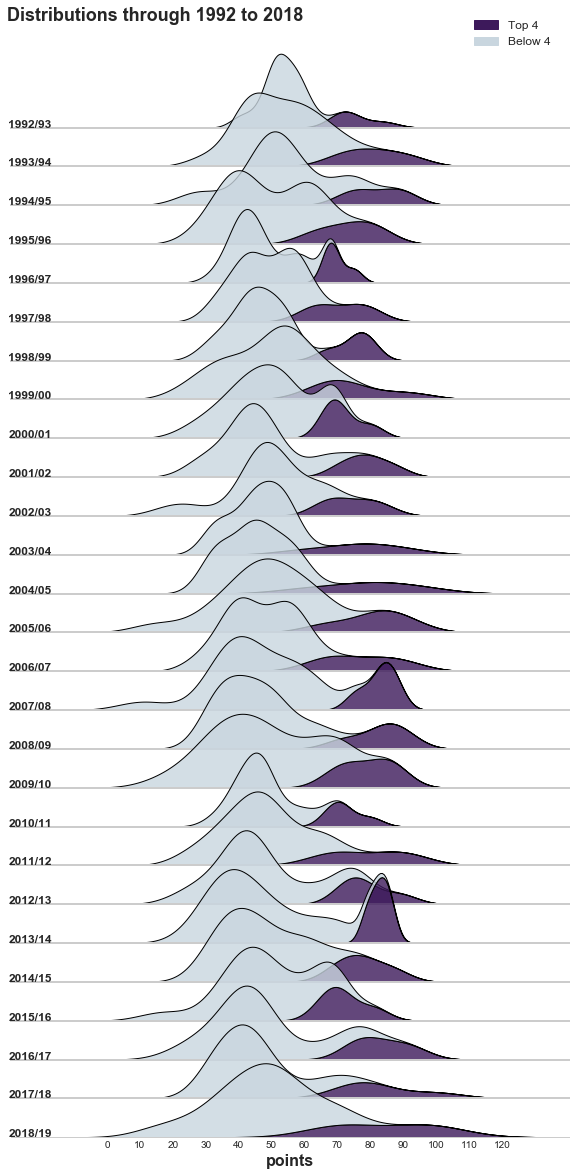

In [20]:
fig, ax = plt.subplots(len(seasons[:-1]), 1, figsize=(10, 20), 
                       sharex=True, gridspec_kw={'hspace':-0.5}, tight_layout=True)

for j, season in enumerate(seasons[:-1]):
    sns.kdeplot(data=data[data['season'] == season], x='points', hue='is_top4',  alpha=.8, 
                edgecolor='black', multiple='stack', legend=False, ax=ax[j])
    
    ax[j].spines['top'].set_visible(False)
    ax[j].spines['right'].set_visible(False)
    ax[j].spines['left'].set_visible(False)
    ax[j].grid(False)
    ax[j].get_yaxis().set_visible(False)
    ax[j].set_facecolor('None')
    
    if j != len(seasons[:-1])-1:
        ax[j].spines['bottom'].set_linewidth(2)
        ax[j].get_xaxis().set_visible(False)
        ax[j].set_xticks(np.arange(0,130,10))
        ax[j].text(-30, 0, season, fontweight='bold', fontsize=12)
    else:
        ax[j].get_xaxis().set_visible(True)
        ax[j].set_xticks(np.arange(0,130,10))
        ax[j].set_xlabel('points', fontsize=16, fontweight='bold')
        ax[j].text(-30, 0, season, fontweight='bold', fontsize=12)

fig.legend(bbox_to_anchor=(0.78, 0.81), handles=[t4_legend, b4_legend], shadow=True, fontsize=12)
fig.text(0.12, 0.9, 'Distributions through 1992 to 2018', fontsize=18, fontweight='bold')     
plt.show()

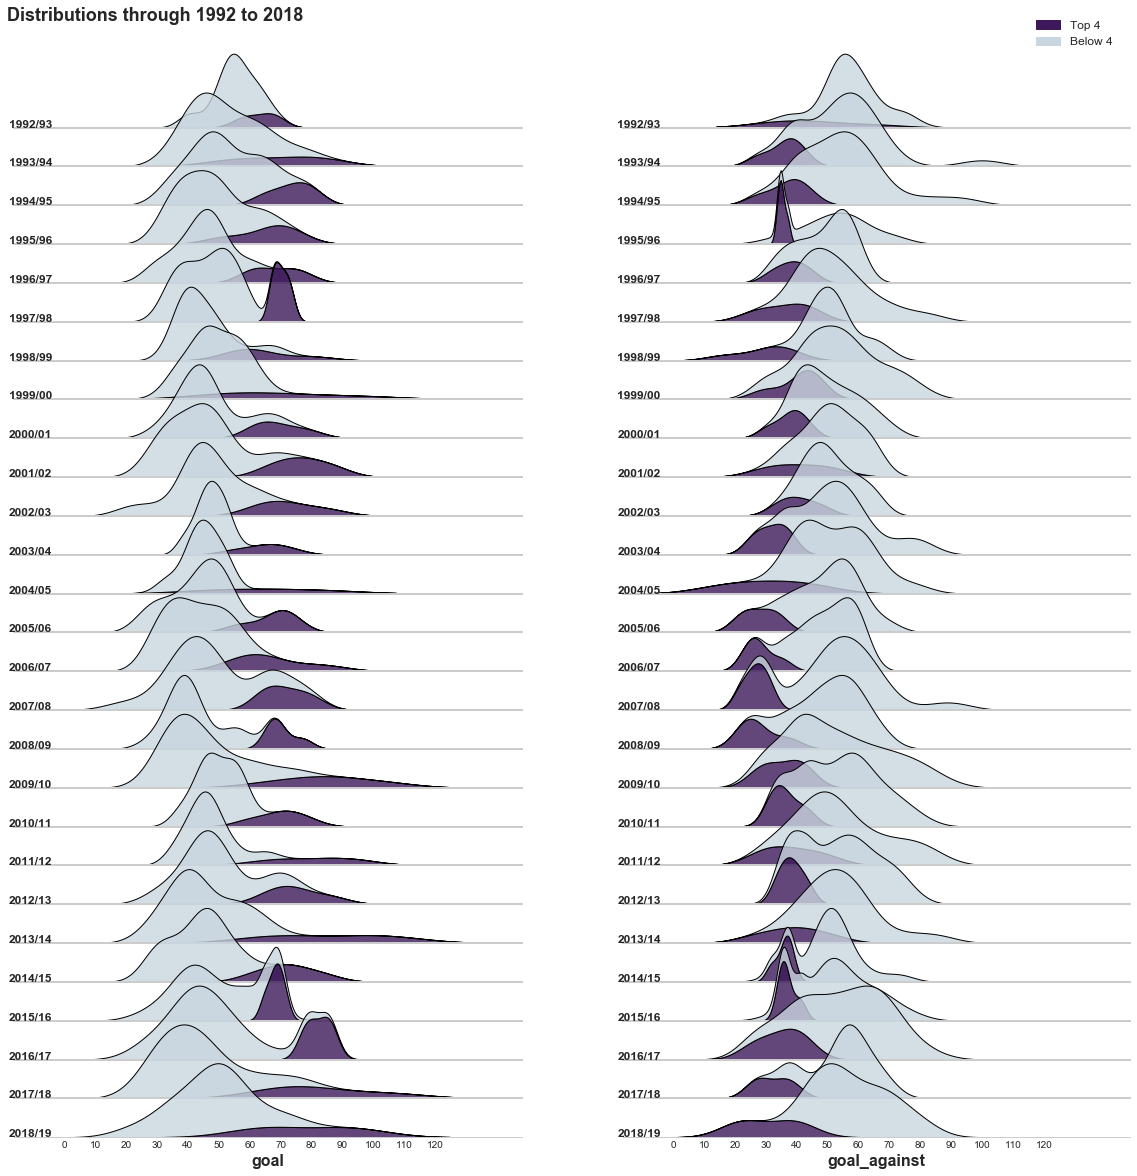

In [21]:
cols = ['goal', 'goal_against']

fig, ax = plt.subplots(len(seasons[:-1]), 2, figsize=(20, 20), 
                       sharex=True, gridspec_kw={'hspace':-0.5}, tight_layout=True)

for i, col in enumerate(cols):
    for j, season in enumerate(seasons[:-1]):
        sns.kdeplot(data=data[data['season'] == season], x=col, hue='is_top4',  alpha=.8, 
                    edgecolor='black', multiple='stack', legend=False, ax=ax[j, i])
        
        ax[j, i].spines['top'].set_visible(False)
        ax[j, i].spines['right'].set_visible(False)
        ax[j, i].spines['left'].set_visible(False)
        ax[j, i].grid(False)
        ax[j, i].get_yaxis().set_visible(False)
        ax[j, i].set_facecolor('None')

        if j != len(seasons[:-1])-1:
            ax[j, i].spines['bottom'].set_linewidth(2)
            ax[j, i].get_xaxis().set_visible(False)
            ax[j, i].text(-18, 0, season, fontweight='bold', fontsize=12)
        else:
            ax[j, i].get_xaxis().set_visible(True)
            ax[j, i].text(-18, 0, season, fontweight='bold', fontsize=12)
            ax[j, i].set_xlabel(col, fontsize=16, fontweight='bold')
            ax[j, i].set_xticks(np.arange(0,130,10))

fig.legend(bbox_to_anchor=(0.78, 0.81), handles=[t4_legend, b4_legend], shadow=True, fontsize=12)
fig.text(0.12, 0.9, 'Distributions through 1992 to 2018', fontsize=18, fontweight='bold')     
plt.show()

**It looks like there is no difference between past and current in term of how many win, lost, draw games are needed to be in the top 4.**

In [22]:
features = ['aerial_battles', 'big_chance_created', 'clearance', 'cross', 'cross_accuracy', 'goal_conceded_per_match', 
            'goal_per_match', 'interceptions', 'pass_accuracy', 'pass_per_game', 'shooting_accuracy', 'shot_on_target', 'tackle_success']

**The data before season 2006 have many features that are zero due to the reason as follows:**  
"When the Premier League began in 1992/93, only a basic level of match data was gathered. Over time this has increased and since 2006/07 a wide range of statistics are now provided. The information below shows a breakdown of the statistics on the Premier League website and the season this data originated." **from EPL offical website, https://www.premierleague.com/stats/clarification**

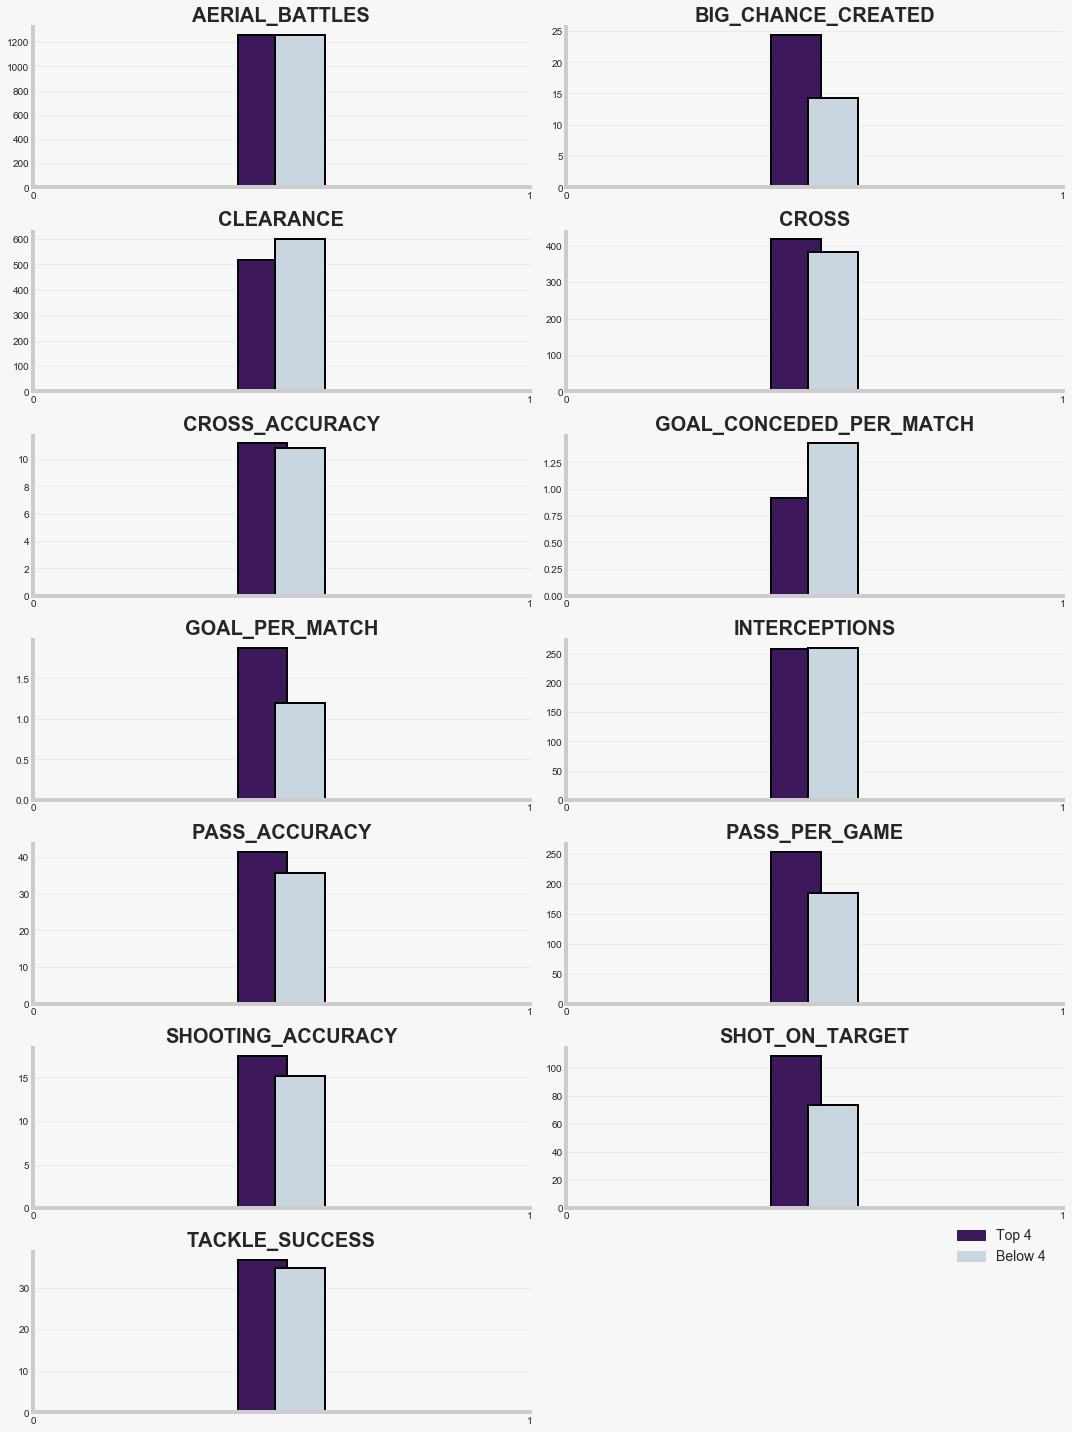

In [23]:
fig, ax = plt.subplots(7, 2, figsize=(15,20))
cols = features

for i, col in enumerate(cols):
    t4_index = top4[col].value_counts().index
    t4_values = np.mean(top4[col])
    b4_index = below4[col].value_counts().index
    b4_values = np.mean(below4[col])

    ax.flatten()[i].bar(x=0.5-0.075/2, height=t4_values, width=0.1, color=t4_color, edgecolor='black', linewidth=2)
    ax.flatten()[i].bar(x=0.5+0.075/2, height=b4_values, width=0.1, color=b4_color, edgecolor='black', linewidth=2)

    ax.flatten()[i].grid(which='major', axis='x', zorder=0, alpha=0.3)
    ax.flatten()[i].grid(which='major', axis='y', zorder=0, alpha=0.3)

    ax.flatten()[i].set_xticks(np.arange(0,2,1))
    ax.flatten()[i].set_title(col.upper(), weight='bold', fontsize=20)
    ax.flatten()[i].set_facecolor(b_color)

    ax.flatten()[i].spines['top'].set_visible(False)
    ax.flatten()[i].spines['right'].set_visible(False)
    ax.flatten()[i].spines['bottom'].set_linewidth(4)
    ax.flatten()[i].spines['left'].set_linewidth(4)

ax.flatten()[-1].set_facecolor(b_color)
ax.flatten()[-1].grid(which='major', axis='x', zorder=0, color=b_color)
ax.flatten()[-1].grid(which='major', axis='y', zorder=0, color=b_color)
ax.flatten()[-1].spines['top'].set_visible(False)
ax.flatten()[-1].spines['right'].set_visible(False)
ax.flatten()[-1].spines['bottom'].set_linewidth(False)
ax.flatten()[-1].spines['left'].set_linewidth(False)
ax.flatten()[-1].get_xaxis().set_visible(False)
ax.flatten()[-1].get_yaxis().set_visible(False)

fig.set_facecolor(b_color)
fig.legend(bbox_to_anchor=(0.98, 0.15), handles=[t4_legend, b4_legend], shadow=True, fontsize=14)
fig.tight_layout()
plt.show()

**The significant different features between Top 4 and Below 4 clubs are 'big_chance_created', 'goal_conceded_per_match', 'goal_per_match', 'pass_per_game', and 'shot_on_target'**  
**In this plots, an interesting part is features that are significant different are kind of obvious features that related to win a match, but there are several features that**

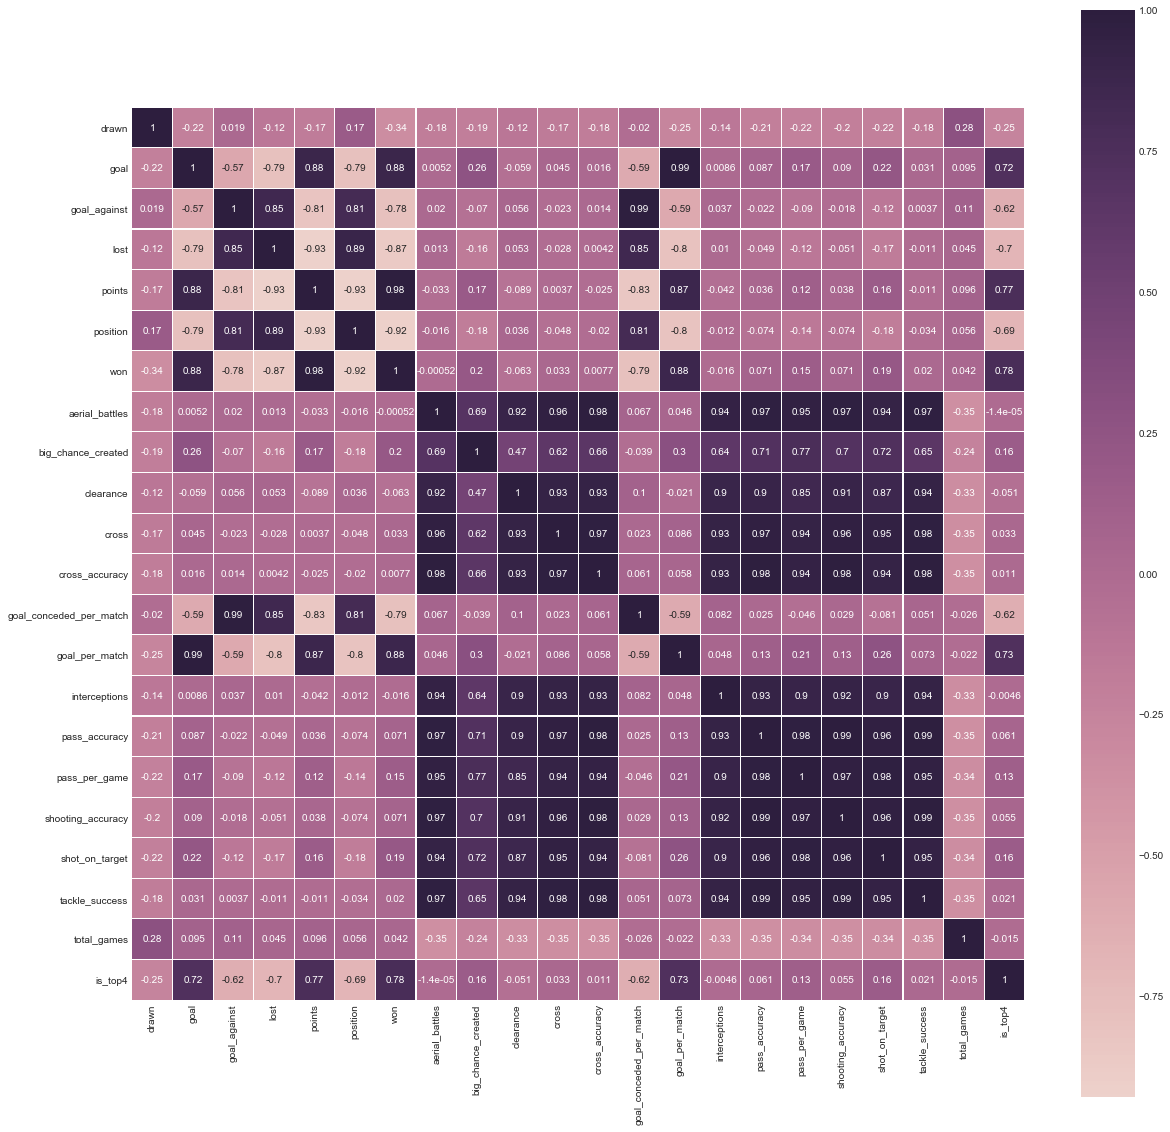

In [24]:
p_season_corr = past_seasons.corr()

plt.figure(figsize=(20,20))
sns.heatmap(p_season_corr, 
            mask=np.zeros_like(p_season_corr, dtype=np.bool), 
            annot=True, cmap=sns.cubehelix_palette(as_cmap=True), square=True, linewidths=0.1)
plt.show()

### ML

#### Selected the periods that have non zero data for club statistics 

In [58]:
train_w = past_seasons[past_seasons['season'] > datetime.date(2010,1,1)]

# Make all the features in average
# Exclude unnecessary features or duplicate infomation
train_w = train_w.drop(['club_name', 'position', 'goal', 'goal_against', 'season', 'total_games'], axis=1)
train_w[['cross_accuracy', 'pass_accuracy', 'shooting_accuracy', 'tackle_success']] = train_w[['cross_accuracy', 'pass_accuracy', 
                                                                                               'shooting_accuracy', 'tackle_success']].apply(lambda x: np.divide(x, 100), axis=1)
train_w.loc[:,:'cross'] = train_w.loc[:,:'cross'].apply(lambda x: np.divide(x, 38), axis=1)
train_w[['interceptions', 'shot_on_target']] = train_w[['interceptions', 'shot_on_target']].apply(lambda x: np.divide(x, 38), axis=1)

In [59]:
def shuffle_data(data, y_name):
    shuffled = shuffle(data)
    X, y = shuffled.drop(y_name, axis=1), shuffled[y_name]
    return X, y

#### Baseline models with every feature

In [60]:
X, y = shuffle_data(train_w, 'is_top4')

# Split the dateset into training and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

# Load empty models
rf = RandomForestClassifier(random_state=42)
svm = SVC(random_state=42)
xb = XGBClassifier(random_state=42)
knn = KNeighborsClassifier()

print(cross_val_score(rf, X, y, cv=5), 
      '-> Average: {}'.format(np.average(cross_val_score(rf, X, y, cv=5))))
print(cross_val_score(svm, X, y, cv=5), 
      '-> Average: {}'.format(np.average(cross_val_score(svm, X, y, cv=5))))
print(cross_val_score(xb, X, y, cv=5), 
      '-> Average: {}'.format(np.average(cross_val_score(xb, X, y, cv=5))))
print(cross_val_score(knn, X, y, cv=5), 
      '-> Average: {}'.format(np.average(cross_val_score(knn, X, y, cv=5))))
print('Overall average: {}'.format((np.average(cross_val_score(rf, X, y, cv=5)) + 
                                    np.average(cross_val_score(svm, X, y, cv=5)) + 
                                    np.average(cross_val_score(xb, X, y, cv=5)) + 
                                    np.average(cross_val_score(knn, X, y, cv=5)))/4), '\n')
rf.fit(X_train, y_train)
svm.fit(X_train, y_train)
xb.fit(X_train, y_train)
knn.fit(X_train, y_train)

# F1 score
print('F1 score', '\n', 'rf-PR: {}'.format(f1_score(y_test, rf.predict(X_test), average='micro')), '\n',
      'svm-PR: {}'.format(f1_score(y_test, svm.predict(X_test), average='micro')), '\n',
      'xb-PR: {}'.format(f1_score(y_test, xb.predict(X_test), average='micro')), '\n',
      'knn-PR: {}'.format(f1_score(y_test, knn.predict(X_test), average='micro')))

[0.89189189 0.94444444 0.94444444 0.91666667 0.91428571] -> Average: 0.9223466323466323
[0.78378378 0.80555556 0.83333333 0.80555556 0.8       ] -> Average: 0.8056456456456456
[0.91891892 0.94444444 0.94444444 0.91666667 0.94285714] -> Average: 0.9334663234663234
[0.83783784 0.91666667 0.86111111 0.86111111 0.82857143] -> Average: 0.861059631059631
Overall average: 0.880629558129558 

F1 score 
 rf-PR: 0.9682539682539683 
 svm-PR: 0.8412698412698413 
 xb-PR: 0.9682539682539683 
 knn-PR: 0.8412698412698413


#### Baseline models with selected features 

In [61]:
selected = ['big_chance_created', 'clearance', 'goal_conceded_per_match', 'goal_per_match', 'pass_per_game',
                   'shot_on_target', 'won', 'lost', 'drawn', 'points']

X_selected = X[selected]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.35, random_state=42)

# Reset the models
rf = RandomForestClassifier(random_state=42)
svm = SVC(random_state=42)
xb = XGBClassifier(random_state=42)
knn = KNeighborsClassifier()

print(cross_val_score(rf, X_selected, y, cv=5), 
      '-> Average: {}'.format(np.average(cross_val_score(rf, X_selected, y, cv=5))))
print(cross_val_score(svm, X_selected, y, cv=5), 
      '-> Average: {}'.format(np.average(cross_val_score(svm, X_selected, y, cv=5))))
print(cross_val_score(xb, X_selected, y, cv=5), 
      '-> Average: {}'.format(np.average(cross_val_score(xb, X_selected, y, cv=5))))
print(cross_val_score(knn, X_selected, y, cv=5), 
      '-> Average: {}'.format(np.average(cross_val_score(knn, X_selected, y, cv=5))))
print('Overall average: {}'.format((np.average(cross_val_score(rf, X_selected, y, cv=5)) + 
                                    np.average(cross_val_score(svm, X_selected, y, cv=5)) + 
                                    np.average(cross_val_score(xb, X_selected, y, cv=5)) + 
                                    np.average(cross_val_score(knn, X_selected, y, cv=5)))/4), '\n')
rf.fit(X_train, y_train)
svm.fit(X_train, y_train)
xb.fit(X_train, y_train)
knn.fit(X_train, y_train)

# F1 score
print('F1 score', '\n', 'rf-PR: {}'.format(f1_score(y_test, rf.predict(X_test), average='micro')), '\n',
      'svm-PR: {}'.format(f1_score(y_test, svm.predict(X_test), average='micro')), '\n',
      'xb-PR: {}'.format(f1_score(y_test, xb.predict(X_test), average='micro')), '\n',
      'knn-PR: {}'.format(f1_score(y_test, knn.predict(X_test), average='micro')))

[0.94594595 0.94444444 0.91666667 0.91666667 0.97142857] -> Average: 0.939030459030459
[0.75675676 0.86111111 0.80555556 0.80555556 0.8       ] -> Average: 0.8057957957957959
[0.91891892 0.97222222 0.94444444 0.91666667 0.94285714] -> Average: 0.939021879021879
[0.83783784 0.91666667 0.83333333 0.88888889 0.82857143] -> Average: 0.861059631059631
Overall average: 0.8862269412269412 

F1 score 
 rf-PR: 0.9682539682539683 
 svm-PR: 0.8412698412698413 
 xb-PR: 0.9682539682539683 
 knn-PR: 0.8253968253968254


**Both datasets have a similar result in accuaracy, but 'selected' has a fewer features. Therefore, it is better to use a dataset that has a fewer features (less complexity).**

#### Baseline models with normalized data

In [62]:
X_norm = np.log(X_selected)

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.35, random_state=42)

# Reset the models
rf = RandomForestClassifier(random_state=42)
svm = SVC(random_state=42)
xb = XGBClassifier(random_state=42)
knn = KNeighborsClassifier()

print(cross_val_score(rf, X_norm, y, cv=5), 
      '-> Average: {}'.format(np.average(cross_val_score(rf, X_norm, y, cv=5))))
print(cross_val_score(svm, X_norm, y, cv=5), 
      '-> Average: {}'.format(np.average(cross_val_score(svm, X_norm, y, cv=5))))
print(cross_val_score(xb, X_norm, y, cv=5), 
      '-> Average: {}'.format(np.average(cross_val_score(xb, X_norm, y, cv=5))))
print(cross_val_score(knn, X_norm, y, cv=5), 
      '-> Average: {}'.format(np.average(cross_val_score(knn, X_norm, y, cv=5))))
print('Overall average: {}'.format((np.average(cross_val_score(rf, X_norm, y, cv=5)) + 
                                    np.average(cross_val_score(svm, X_norm, y, cv=5)) + 
                                    np.average(cross_val_score(xb, X_norm, y, cv=5)) + 
                                    np.average(cross_val_score(knn, X_norm, y, cv=5)))/4), '\n')
rf.fit(X_train, y_train)
svm.fit(X_train, y_train)
xb.fit(X_train, y_train)
knn.fit(X_train, y_train)

# F1 score
print('F1 score', '\n', 'rf-PR: {}'.format(f1_score(y_test, rf.predict(X_test), average='micro')), '\n',
      'svm-PR: {}'.format(f1_score(y_test, svm.predict(X_test), average='micro')), '\n',
      'xb-PR: {}'.format(f1_score(y_test, xb.predict(X_test), average='micro')), '\n',
      'knn-PR: {}'.format(f1_score(y_test, knn.predict(X_test), average='micro')))

[0.94594595 0.94444444 0.94444444 0.91666667 0.97142857] -> Average: 0.9445860145860145
[0.94594595 0.97222222 0.97222222 0.91666667 0.94285714] -> Average: 0.9499828399828398
[0.91891892 0.97222222 0.94444444 0.91666667 0.94285714] -> Average: 0.939021879021879
[0.94594595 0.97222222 0.91666667 0.91666667 1.        ] -> Average: 0.9503003003003002
Overall average: 0.9459727584727583 

F1 score 
 rf-PR: 0.9682539682539683 
 svm-PR: 0.9682539682539683 
 xb-PR: 0.9682539682539683 
 knn-PR: 0.9841269841269841


**The best overall performance is Random Forest whether the dataset contains every feature, selected features, and normalized data. Since Random Forest performed the best with normalized data, we will use Random Forest to predict the target variable and do hyperparameter tuning to oprimize the model.**

#### Hyperparameter tuning for Random Foreset

In [63]:
start_time = time.time()
# reset Random Forest model
rf = RandomForestClassifier(random_state=42)

# Create grid parameter for the model
r_params = {'n_estimators': [3, 5, 10, 15, 20, 30],
            'max_features': ['auto', 'sqrt', 'log2'],
            'min_samples_split': [2, 3, 4, 5, 8, 10],
            'min_samples_leaf': [1, 2, 3, 4, 5, 9],
            'oob_score': [True, False]}

rs = GridSearchCV(rf, r_params, scoring='f1_micro', cv=5)
rs.fit(X_norm, y)
print(time.time() - start_time, '[sec]', '\n', 'Best parameters: ', rs.best_params_)

87.2238450050354 [sec] 
 Best parameters:  {'max_features': 'auto', 'min_samples_leaf': 9, 'min_samples_split': 2, 'n_estimators': 30, 'oob_score': True}


In [64]:
best_rf = RandomForestClassifier(oob_score=True, n_estimators=30, min_samples_leaf=9, 
                                 min_samples_split=2, max_features='auto', random_state=42)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.35, random_state=42)
best_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=9, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [66]:
np.average(cross_val_score(best_rf, X_norm, y, cv=5))

0.9612526812526813

In [67]:
f1_score(y_test, best_rf.predict(X_test), average='micro')

0.9682539682539683

**After hyperparameter tuning, accuracy got better, but F1 score stayed same. 96% in accuracy and 0.95 in F1 score is still pretty good. Let's make a prediction on the current season, which is 2019/20**

In [68]:
# This is for the result
new_c_season = current_season[['club_name', 'position']]

# Data preprocessing for current season
current_season = current_season.drop(['club_name', 'position', 'goal', 'goal_against', 'season'], axis=1)
current_season[['cross_accuracy', 'pass_accuracy', 'shooting_accuracy', 'tackle_success']] = current_season[['cross_accuracy', 'pass_accuracy', 
                                                                                               'shooting_accuracy', 'tackle_success']].apply(lambda x: np.divide(x, 100), axis=1)

for i in range(len(current_season)):
    current_season.loc[i,'drawn':'cross'] = current_season.loc[i,:'cross'].apply(lambda x: np.divide(x, current_season['total_games'][i]))
    current_season.loc[i, ['interceptions', 'shot_on_target']] = current_season.loc[i, ['interceptions', 'shot_on_target']].apply(lambda x: np.divide(x, current_season['total_games'][i]))

n_current_season = pd.merge(new_c_season, current_season, right_index=True, left_index=True)

X, y = n_current_season.drop(['club_name', 'position'], axis=1), n_current_season['is_top4']
X = np.log(X[selected])

# Compare with current standing
result = n_current_season[['club_name', 'position']]
result['P(not top4)'], result['P(top4)'] = best_rf.predict_proba(X)[:,0], best_rf.predict_proba(X)[:,1]

result

,club_name,position,P(not top4),P(top4)
0,Liverpool,1,0.056245,0.943755
1,Manchester City,2,0.320613,0.679387
2,Leicester City,3,0.414397,0.585603
3,Chelsea,4,0.755635,0.244365
4,Manchester United,5,0.800618,0.199382
5,Wolverhampton Wanderers,6,0.911131,0.088869
6,Sheffield United,7,0.787898,0.212102
7,Tottenham Hotspur,8,0.972096,0.027904
8,Arsenal,9,0.910682,0.089318
9,Burnley,10,0.990611,0.009389
